In [2]:
import pandas as pd
from deepface import DeepFace
from typing import List, Tuple
import numpy as np
import os
import cv2

#### Путь к датасету

In [3]:
dataset_path = '../datasets/facescrub_images/'

#### Функция для парсинга файлов-изображений

In [4]:
def list_images(path):
    """Create default dict with img paths"""
    imgs_list = []
    for dir in os.listdir(path):
        full_path = os.path.join(path, dir)
        for img_name in os.listdir(full_path):
            img_path = os.path.join(full_path, img_name)         
            if img_path.endswith('.png') or img_path.endswith('.jpg') or img_path.endswith('.jpeg') :
                imgs_list.append((img_path, dir, img_name))
    return imgs_list

#### Сохраним пути к изображениям в список

In [5]:
imgs_list = list_images(dataset_path)

#### Преобразуем список в датафрейм

In [6]:
imgs_df = pd.DataFrame(imgs_list, columns=['img_path', 'name', 'img_name'])
imgs_df.head()

,img_path,name,img_name
0,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34645.png
1,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34540.png
2,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34523.png
3,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34537.png
4,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34545.png


#### Посчитаем статистику датасета

In [7]:
grouped_df = imgs_df.groupby(['name'])['name'].agg('count')
print("Количество всего изображений:", imgs_df.shape[0])
print("Среднее количество изображений на одного человека:", int(grouped_df.mean()))
print("Минимальное количество изображений на одного человека:", int(grouped_df.min()))
print("Максимальное количество изображений на одного человека:", int(grouped_df.max()))
print("Количество уникальных людей:", int(grouped_df.shape[0]))

Количество всего изображений: 3530
Среднее количество изображений на одного человека: 44
Минимальное количество изображений на одного человека: 27
Максимальное количество изображений на одного человека: 50
Количество уникальных людей: 80


#### Разделение датасета на две выборки: распологаемую в БД и тестовую

In [8]:
def split_dataset(df: pd.DataFrame, db_count: int) -> Tuple[pd.DataFrame]:
    """Split init df to db and test dfs

    Args:
        df (pd.DataFrame): initial df
        db_count (int): how many object per person should be in DB

    Returns:
        Tuple[pd.DataFrame]: db_df, test_df
    """    
    imgs_db_df = df[df['obj_row'] <= db_count]
    imgs_test_df = df[df['obj_row'] > db_count]
    return imgs_db_df, imgs_test_df

### Создание эмбеддингов изображений

In [9]:
def get_emb_list_from_df(img_df: pd.DataFrame, embedding_model, backend_model) -> list:
    emb_list = []
    errors_list = []
    for path, name, img_name, row in img_df.values:
        try:
            faces_obj = DeepFace.represent(path, model_name=embedding_model, detector_backend=backend_model)
            embedding = np.array(faces_obj[0]['embedding'])
            emb_list.append((name, img_name, path, embedding))
        except:
            #print("Can't detect face", name, row)
            errors_list.append((name, path, row))
        
    return emb_list, errors_list

### Загружаем выборку в БД

#### Количество измерений на выходе модели

#### Создание таблицы

In [10]:
def create_pg_connection():
    env = Env()
    env.read_env('../.env', recurse=False)
    conn=pg.connect(
        dbname='maska',
        user='postgres',
            password= env.str('PSQL_PASSWORD'),
            host='localhost',
            port='5432' )
    cursor = conn.cursor()
    return conn, cursor

In [11]:
def create_table(vector_size, conn, cursor):
    table_name='faces_test'
    cursor.execute(f"DROP TABLE IF EXISTS {table_name}")
    cursor.execute(f"CREATE TABLE IF NOT EXISTS {table_name} (id bigserial PRIMARY KEY, name varchar(30), img_name varchar(50), img_path text, embedding vector({vector_size}))")
    conn.commit()

#### Запись значений в БД

In [12]:
def insert_values(embeddings, conn, cursor):
    for name, img_name, path, embedding in embeddings:        
        embedding = list(embedding)
        cursor.execute(f"INSERT INTO faces_test (name, img_name, img_path, embedding) VALUES (%s, %s, %s, %s)", (name, img_name, path, embedding))
        conn.commit()    

#### Скопируем тестовые изображения и изображения находящтеся в БД в определенную папку

Удалим старые изображения

In [13]:
import shutil, os


def del_dirs():
    
    test_folder = '../datasets/model_test/test'
    database_folder = '../datasets/model_test/database'
    def delete_dir_content(folder):
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))
            
    delete_dir_content(test_folder)
    delete_dir_content(database_folder)

In [14]:
def copy_imgs(db_df, test_df):
    test_folder = '../datasets/model_test/test'
    database_folder = '../datasets/model_test/database'
    folders = ((test_folder, test_df), (database_folder, db_df))
    for folder, df in folders:
        images = [path for path, name, img_name, row in df.values]
        for f in images:
            shutil.copy(f, folder)

## Предсказываем людей по тестовым фото, сравнивая фото с изображениями в БД

Найдем в БД ближайшего человека

In [15]:
def model_predict(test_embeddings, cursor):
    predictions = []
    for name, img_name, path, embedding  in test_embeddings:
        embedding = list(embedding)
        cursor.execute(f"SELECT name FROM faces_test ORDER BY embedding <=> %s::vector LIMIT 1", (embedding,))
        predictions.extend(cursor.fetchone())
    return predictions

### Измерим качество предсказания

In [16]:
def get_scores(predict_names, actual_names):
    accuracy = 100*accuracy_score(actual_names, predict_names)
    precision = 100*precision_score(actual_names, predict_names, average='weighted')
    recall = 100*recall_score(actual_names, predict_names, average='weighted')
    f1 = 100*f1_score(actual_names, predict_names, average='weighted')
    scores = (accuracy, precision, recall, f1)
    return scores

In [17]:
from collections import Counter
from environs import Env
import psycopg2 as pg

from deepface import DeepFace
from deepface.basemodels import ArcFace, VGGFace, FbDeepFace, SFace, Facenet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = [ArcFace.ArcFaceClient().model_name, VGGFace.VggFaceClient().model_name, FbDeepFace.DeepFaceClient().model_name, SFace.SFaceClient().model_name, Facenet.FaceNet512dClient().model_name]



def main():
    model_scores = []
    df = imgs_df.copy()
    # numerize photos per person
    df['obj_row'] = df.groupby(['name']).cumcount() + 1
    db_counts = [3, 10, 25]
    # list of model_names
    models = [ArcFace.ArcFaceClient().model_name, VGGFace.VggFaceClient().model_name, FbDeepFace.DeepFaceClient().model_name, SFace.SFaceClient().model_name, Facenet.FaceNet512dClient().model_name]
    # list of model vector sizes
    model_size = [ArcFace.ArcFaceClient().output_shape, VGGFace.VggFaceClient().output_shape, FbDeepFace.DeepFaceClient().output_shape, SFace.SFaceClient().output_shape, Facenet.FaceNet512dClient().output_shape]
    backend_model = 'opencv'
    for count in db_counts:
        # split images DF to DB and test sets
        db_df, test_df = split_dataset(df, count)
        for model, size in zip(models, model_size):
            print(f"Model: {model}. DB_count: {count}. Get embeddings from DB images: {db_df.shape[0]}")
            # get embeddings from DB set
            imgs_db_embeddings, db_errors = get_emb_list_from_df(db_df, model, backend_model) 
            print(f"Model: {model}. DB_count: {count}. Got embeddings. Can't detected {len(db_errors)} images")
            # find names of people which all photos can't recognized
            names = [name for name, path, row in db_errors]
            counts = Counter(names)
            error_names = [name for name, err_count in counts.items() if err_count >= count]
            if error_names:
                test_df = test_df[~test_df['name'].isin(error_names)]
            # create pg connection
            conn, cursor = create_pg_connection()
            create_table(size, conn, cursor)
            print("Запись данных в БД")
            insert_values(imgs_db_embeddings, conn, cursor)
            # del_dirs()
            # copy_imgs(db_df, test_df)
            print(f"Model: {model}.  DB_count: {count}. Get embeddings from Test images: {test_df.shape[0]}")
            # get embeddings from Test set
            test_embeddings, test_errors = get_emb_list_from_df(test_df, model, backend_model)
            print(f"Model: {model}. DB_count: {count}. Got embeddings. Can't detected {len(test_errors)} images")
            predict_names = model_predict(test_embeddings, cursor)            
            actual_names = [name for name, img_name, path, embedding in test_embeddings]
            scores = get_scores(predict_names, actual_names)
            model_scores.append((model, size, count, db_df.shape[0], test_df.shape[0], len(db_errors), len(test_errors), *scores))
            conn.close()
    return model_scores
            
scores = main()   

Model: ArcFace. DB_count: 3. Get embeddings from DB images: 240
Model: ArcFace. DB_count: 3. Got embeddings. Can't detected 7 images
Запись данных в БД
Model: ArcFace.  DB_count: 3. Get embeddings from Test images: 3290
Model: ArcFace. DB_count: 3. Got embeddings. Can't detected 180 images
Model: VGG-Face. DB_count: 3. Get embeddings from DB images: 240
Model: VGG-Face. DB_count: 3. Got embeddings. Can't detected 7 images
Запись данных в БД
Model: VGG-Face.  DB_count: 3. Get embeddings from Test images: 3290
Model: VGG-Face. DB_count: 3. Got embeddings. Can't detected 180 images
Model: DeepFace. DB_count: 3. Get embeddings from DB images: 240
Model: DeepFace. DB_count: 3. Got embeddings. Can't detected 7 images
Запись данных в БД
Model: DeepFace.  DB_count: 3. Get embeddings from Test images: 3290
Model: DeepFace. DB_count: 3. Got embeddings. Can't detected 180 images
Model: SFace. DB_count: 3. Get embeddings from DB images: 240
Model: SFace. DB_count: 3. Got embeddings. Can't detected

In [21]:
import pickle

pickle.dump(scores, open("scores.pkl", 'wb'))

In [24]:
scores_df= pd.DataFrame(scores, columns=['model', 'vector_size', 'pic_in_db', 'db_img_count', 'test_img_count', 'errors_db', 'errors_test', 'accuracy', 'precision', 'recall', 'f1'])

In [26]:
scores_df.sort_values(by='model')

,model,vector_size,pic_in_db,db_img_count,test_img_count,errors_db,errors_test,accuracy,precision,recall,f1
0,ArcFace,512,3,240,3290,7,180,96.141479,96.389178,96.141479,96.116922
5,ArcFace,512,10,800,2730,46,141,97.759753,97.946562,97.759753,97.778140
10,ArcFace,512,25,2000,1530,109,78,98.829201,98.894727,98.829201,98.830753
2,DeepFace,4096,3,240,3290,7,180,21.929260,28.992771,21.929260,21.979505
7,DeepFace,4096,10,800,2730,46,141,36.384705,42.771245,36.384705,36.950189
12,DeepFace,4096,25,2000,1530,109,78,48.278237,53.428495,48.278237,48.971007
4,FaceNet-512d,512,3,240,0,240,0,NaN,NaN,NaN,NaN
9,FaceNet-512d,512,10,800,0,800,0,NaN,NaN,NaN,NaN
14,FaceNet-512d,512,25,2000,0,2000,0,NaN,NaN,NaN,NaN
3,SFace,128,3,240,3290,7,180,88.520900,89.529509,88.520900,88.459138


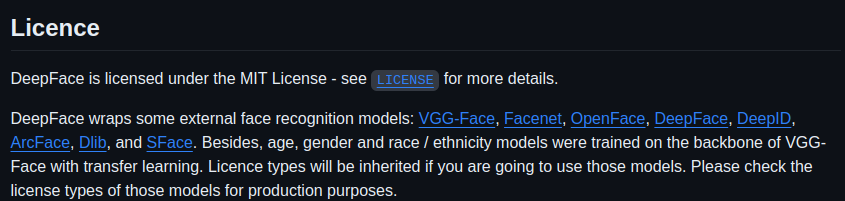

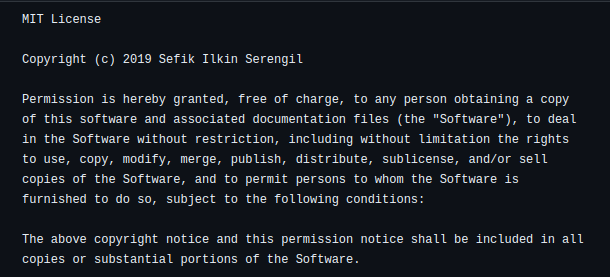